In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

df = pd.read_csv("~/Desktop/s25/5243 ADS/5243-Project1/5243_raw_data.csv" )
print(df.head())

                                       property_name areaWithType square_feet  \
0          2 BHK Apartment for Sale in Dindoli Surat  Carpet Area    644 sqft   
1           2 BHK Apartment for Sale in Althan Surat   Super Area   1278 sqft   
2          2 BHK Apartment for Sale in Pal Gam Surat   Super Area   1173 sqft   
3     2 BHK Apartment for Sale in Jahangirabad Surat  Carpet Area    700 sqft   
4  2 BHK Apartment for Sale in Orchid Fantasia, P...   Super Area   1250 sqft   

       transaction            status        floor      furnishing  \
0     New Property  Poss. by Oct '24  5 out of 10     Unfurnished   
1     New Property  Poss. by Jan '26  6 out of 14     Unfurnished   
2           Resale     Ready to Move  5 out of 13  Semi-Furnished   
3     New Property     Ready to Move  6 out of 14     Unfurnished   
4  Orchid Fantasia      New Property  Unfurnished               2   

        facing                                        description  \
0         West  Luxury projec

In [3]:
print(df.shape)
print(df.columns)
df.head()

(4525, 11)
Index(['property_name', 'areaWithType', 'square_feet', 'transaction', 'status',
       'floor', 'furnishing', 'facing', 'description', 'price_per_sqft',
       'price'],
      dtype='object')


,property_name,areaWithType,square_feet,transaction,status,floor,furnishing,facing,description,price_per_sqft,price
0,2 BHK Apartment for Sale in Dindoli Surat,Carpet Area,644 sqft,New Property,Poss. by Oct '24,5 out of 10,Unfurnished,West,"Luxury project with basement parking, Solar ro...","₹2,891 per sqft",₹33.8 Lac
1,2 BHK Apartment for Sale in Althan Surat,Super Area,1278 sqft,New Property,Poss. by Jan '26,6 out of 14,Unfurnished,South -West,2 And 3 BHK Luxurious Flat for Sell In New Alt...,"₹3,551 per sqft",₹45.4 Lac
2,2 BHK Apartment for Sale in Pal Gam Surat,Super Area,1173 sqft,Resale,Ready to Move,5 out of 13,Semi-Furnished,East,This affordable 2 BHK flat is situated along a...,"₹3,800 per sqft",₹44.6 Lac
3,2 BHK Apartment for Sale in Jahangirabad Surat,Carpet Area,700 sqft,New Property,Ready to Move,6 out of 14,Unfurnished,East,2 BHK Flat For sell IN Jahangirabad Prime Loca...,"₹3,966 per sqft",₹47 Lac
4,"2 BHK Apartment for Sale in Orchid Fantasia, P...",Super Area,1250 sqft,Orchid Fantasia,New Property,Unfurnished,2,2,"Multistorey Apartment for Sale in Palanpur, Su...","₹3,600 per sqft",₹45 Lac


**Data Cleaning and Handling Inconsistencies**
1. Checking Duplicates

In [4]:
initial_shape = df.shape
df = df.drop_duplicates()
print(initial_shape)
print(df.shape)
print(f'We remove {initial_shape[0] - df.shape[0]} duplicates.')

(4525, 11)
(4416, 11)
We remove 109 duplicates.


2. Standardizing Area Units (*square_feet*)


In [5]:
#Deal with the Unit.
#Before we change the data, make a copy just in case we may still need it
df['square_feet_copy'] = df['square_feet'].copy()

#We need check if the data use same unit.
df['square_feet_unit'] = df['square_feet'].str.extract(r'([a-zA-Z]+)$')
print(f'Area unit:{df.square_feet_unit.unique()}')

#looks like they use differet unit
#first change the wrong data to nan
valid_units = ['sqm', 'sqyrd', 'acre', 'sqft']
df['square_feet'] = np.where(df['square_feet_unit'].isin(valid_units), df['square_feet'], np.nan)

#second transfrom all unit to sqft
df.square_feet = df.square_feet.str.replace(r'\b(sqm|sqyrd|acre|sqft)\b', '', regex=True)
df.square_feet = pd.to_numeric(df.square_feet, errors='coerce')
df.loc[df['square_feet_unit'] == 'sqm', 'square_feet'] *= 10.7639
df.loc[df['square_feet_unit'] == 'sqyrd', 'square_feet'] *= 9
df.loc[df['square_feet_unit'] == 'acre', 'square_feet'] *= 43560
df.rename(columns={'square_feet': 'area_sqft'}, inplace=True)


Area unit:['sqft' 'sqm' 'sqyrd' 'Resale' 'Move' 'acre' 'rood' 'ground']


3. Standardizing Price and Price Per Square Foot (*price*)

In [6]:
#now let's check price unit
df.price = df.price.str.replace('₹', '')
df[['price', 'price_unit']] = df['price'].str.extract(r'([\d.]+)\s*(\w+)', expand=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')
print(f'Price Unit{df.price_unit.unique()}')
valid_price_units = ['Lac','Cr']
df['price'] = np.where(df['price_unit'].isin(valid_price_units), df['price'], np.nan)
df.loc[df['price_unit'] == 'Cr', 'price'] *= 100
df.rename(columns={'price': 'price_Lac'}, inplace=True)

Price Unit['Lac' nan 'Cr']


In [7]:
#now let's check price_per_sqft unit
df['price_per_sqft'] = df['price_per_sqft'].str.replace('₹', '').str.strip()
df[['price_per_sqft', 'price_per_sqft_unit']] = df['price_per_sqft'].str.extract(r'([\d,]+)\s*per\s*([a-zA-Z]+)', expand=True)
print(f'before: {df.price_per_sqft_unit.unique()}')
#good, looks like the price_per_sqft have same unit
valid_price_per_sqft_units = ['sqft']
df['price_per_sqft'] = np.where(df['price_per_sqft_unit'].isin(valid_price_per_sqft_units), df['price_per_sqft'], np.nan)
#change to number
df.price_per_sqft = df.price_per_sqft.str.replace(',', '')
df['price_per_sqft'] = pd.to_numeric(df['price_per_sqft'], errors='coerce')

before: ['sqft' nan]


In [8]:
df.head()

,property_name,areaWithType,area_sqft,transaction,status,floor,furnishing,facing,description,price_per_sqft,price_Lac,square_feet_copy,square_feet_unit,price_unit,price_per_sqft_unit
0,2 BHK Apartment for Sale in Dindoli Surat,Carpet Area,644.0,New Property,Poss. by Oct '24,5 out of 10,Unfurnished,West,"Luxury project with basement parking, Solar ro...",2891.0,33.8,644 sqft,sqft,Lac,sqft
1,2 BHK Apartment for Sale in Althan Surat,Super Area,1278.0,New Property,Poss. by Jan '26,6 out of 14,Unfurnished,South -West,2 And 3 BHK Luxurious Flat for Sell In New Alt...,3551.0,45.4,1278 sqft,sqft,Lac,sqft
2,2 BHK Apartment for Sale in Pal Gam Surat,Super Area,1173.0,Resale,Ready to Move,5 out of 13,Semi-Furnished,East,This affordable 2 BHK flat is situated along a...,3800.0,44.6,1173 sqft,sqft,Lac,sqft
3,2 BHK Apartment for Sale in Jahangirabad Surat,Carpet Area,700.0,New Property,Ready to Move,6 out of 14,Unfurnished,East,2 BHK Flat For sell IN Jahangirabad Prime Loca...,3966.0,47.0,700 sqft,sqft,Lac,sqft
4,"2 BHK Apartment for Sale in Orchid Fantasia, P...",Super Area,1250.0,Orchid Fantasia,New Property,Unfurnished,2,2,"Multistorey Apartment for Sale in Palanpur, Su...",3600.0,45.0,1250 sqft,sqft,Lac,sqft


4. Categorical Variables Cleaning (*areaWithType, transaction, status, floor, furnishing, facing*)

In [9]:
#Since this is uncleaned data, we need to check whether the data in each variable is correct.
print(f'before:{df.areaWithType.unique()}')

#Carpet Area, Super Area, Plot Area, Built Area are make sence.
#But the others look like wrong data, so we replace them with nan
keep_areaWithType = ['Carpet Area', 'Super Area','Plot Area','Built Area']
df.areaWithType = df.areaWithType.apply(lambda x: x if x in keep_areaWithType else np.nan)
print(f'after:{df.areaWithType.unique()}')

before:['Carpet Area' 'Super Area' 'Plot Area' 'Built Area' 'Transaction'
 'Status']
after:['Carpet Area' 'Super Area' 'Plot Area' 'Built Area' nan]


In [10]:
#let move on another variable: transaction
print(f'before:{df.transaction.unique()}')

#Just like the previous step, we only save the data that make sence.
#At the same time, we also noticed that there is information about whether it is furnished.
#It is possible that the data has been filled in in the wrong location.
#This data may be useful when cleaning furnished variables, so we make a copy of origional transaction data for later use.
df['transaction_copy'] = df['transaction'].copy()
keep_transaction = ['New Property','Resale']
df.transaction = df.transaction.apply(lambda x: x if x in keep_transaction else np.nan)
print(f'after:{df.transaction.unique()}')

before:['New Property' 'Resale' 'Orchid Fantasia' 'Unfurnished' 'Orchid Gardenia'
 'Congo' 'Furnished' nan 'Semi-Furnished' 'Main Road, Garden/Park' '1' '3'
 '4' 'Yes' 'No' 'Mahavir Nagar' '3 Covered' 'Shagun Residency' '2'
 'Main Road' '10 m' 'Other' '1 Covered' 'Soham Elegance' 'Garden/Park'
 'Aakash Echo Point' 'Sundaram Residency' '5' 'Jolly Residency'
 'Mangalam Heights' 'Green City' 'Pool, Garden/Park, Main Road' '6'
 'Co-operative Society' 'Vatsalya Bungalows' '20 Covered,'
 'Raghuvir Silverstone' '8 m' 'Casa Rivera']
after:['New Property' 'Resale' nan]


In [11]:
#let move on another variable: status
print(f'before:{df.status.unique()}')
#Just like the previous reason, there may be some data in the wrong position in the status data.
#Therefore we make a copy of origional data for later use.
df['status_copy'] = df['status'].copy()

#When we observe the data, we can find that there is a lot of data that is about possible after a certain date.
#For better analysis, we can simplify these data. Here we replace these data with "Not Ready"
df.loc[df['status'].str.contains('Poss', na=False), 'status'] = 'Not Ready'
keep_status = ['Ready to Move','Not Ready']
df.status = df.status.apply(lambda x: x if x in keep_status else np.nan)
print(f'after:{df.status.unique()}')

before:["Poss. by Oct '24" "Poss. by Jan '26" 'Ready to Move' 'New Property'
 "Poss. by Dec '25" "Poss. by Jun '24" "Poss. by Sep '25"
 "Poss. by Feb '26" '1 out of 7' "Poss. by Jul '24" "Poss. by Dec '26"
 "Poss. by Apr '25" "Poss. by Jan '25" 'Freehold' '21 X 50.2'
 "Poss. by Dec '24" "Poss. by Aug '25" "Poss. by Feb '25" '3 out of 10'
 'Resale' 'Co-operative Society' '120 X 105' '3 out of 7'
 "Poss. by May '26" '36 X 15' "Poss. by Aug '24" '2' '3 out of 3'
 '52.5 X 32.1' '3 out of 5' '5 out of 5' '12 X 35.92' '13 out of 14'
 '7.29 X 14' '4 out of 5' 'Ground out of 1' '3 out of 4'
 'Ground out of 10' 'Ground out of 2' '20 X 40' '16.4 X 60' '11 out of 14'
 '9.42 X 126' '25 X 12' nan '2 out of 4' '54 X 15' '21 X 57'
 'Power Of Attorney' "Poss. by Jul '25" "Poss. by May '25"
 "Poss. by Mar '26" "Poss. by Jun '26" "Poss. by Nov '24" '26.7 X 55.6'
 "Poss. by Jun '25" "Poss. by Mar '25" '41 X 20' "Poss. by Apr '26"
 '5 out of 13' '36 X 21' '19.2 X 54.8' '8 out of 14' '26.7 X 54.9'
 '38 X 2

In [12]:
#let move on another variable: floor
print(f'before:{df.floor.unique()}')
#same reason. We make a copy.
df['floor_copy'] = df['floor'].copy()
#This representation of floors is difficult to analyze as a variable in subsequent analyses.
#So we convert it from string to number
#The floor expression method uses the British method.
#In order to better understand the data, we convert it to the American method.
#eg：we count floor from 1 not from 0 or ground
df.floor = df.floor.str.replace('Ground', '0')
df.floor = df.floor.str.replace('Upper Basement', '-1')
df.floor = df.floor.str.replace('Lower Basement', '-2')
df[['property_floor', 'total_floor']] = df['floor'].apply(lambda x: x.split(' out of ') if 'out of' in str(x) else [np.nan, np.nan]).apply(pd.Series)
df['property_floor'] = pd.to_numeric(df['property_floor'], errors='coerce')
df['total_floor'] = pd.to_numeric(df['total_floor'], errors='coerce')
df.loc[df['property_floor'] >= 0, 'property_floor'] += 1
df.loc[df['total_floor'] >= 0, 'total_floor'] += 1
print(df['property_floor'].head())
print(df['total_floor'].head())

before:['5 out of 10' '6 out of 14' '5 out of 13' 'Unfurnished' 'New Property'
 '7 out of 10' '3 out of 14' '6 out of 13' '1 out of 1' '1 out of 13'
 '4 out of 7' '3 out of 3' '2 out of 6' '3 out of 5' '2 out of 5'
 '3 out of 12' '5 out of 5' 'Resale' 'Ground out of 1'
 'Lower Basement out of 7' '1 out of 5' '7 out of 14' '9 out of 14'
 '5 out of 12' '7 out of 13' '1 out of 2' '2 out of 10' 'Freehold'
 '12 out of 14' '10 out of 14' '2 out of 12' '1 out of 4' '13 out of 14'
 '4 out of 14' '6 out of 10' '2 out of 4' '3 out of 4' '9 out of 13'
 'Upper Basement out of 5' '3 out of 10' '1 out of 3' '4 out of 4'
 'Ground out of 2' 'Lower Basement out of 2' 'Ground out of 4' nan
 'Ground out of 5' '4 out of 10' 'Ground out of 14' 'Ground out of 6'
 '5 out of 6' '8 out of 9' '4 out of 5' '2 out of 7' '7 out of 7'
 'Ground out of 3' '4 out of 8' '8 out of 14' '6 out of 7' '7 out of 11'
 'Upper Basement out of 4' 'Furnished' 'Congo' '3' '2 out of 3'
 '1 out of 7' 'Ground' '1 out of 6' '9 out of 

In [13]:
#let move on another variable: furnishing
print(f'before:{df.furnishing.unique()}')
#same reason. We make a copy.
df['furnishing_copy'] = df['furnishing'].copy()
#Unfurnished,Semi-Furnished,Furnished looks make sence.
#But the others look like wrong data, so we replace them with nan
keep_furnishing = ['Unfurnished','Semi-Furnished','Furnished']
df.furnishing = df.furnishing.apply(lambda x: x if x in keep_furnishing else np.nan)
print(f'after:{df.furnishing.unique()}')

before:['Unfurnished' 'Semi-Furnished' '2' 'Anand Aspire' 'East' '1' 'Furnished'
 nan '3' '1 Covered,' '2 Covered' '1 Covered' 'Freehold' 'West'
 '26 Covered' 'Main Road' 'No' 'North' '1 Open' '6' 'Co-operative Society'
 '> 10' '4' 'Nilkanth Seven Homes' 'Aagam Navkar' '10 Open'
 'Vinayak Enclave' '5 Covered,' 'South -West'
 'Pool, Garden/Park, Main Road' 'Garden/Park, Main Road' '7 m' '30 m'
 '50 Covered,' 'South' '12 m' 'Yes' 'Gruham Luxuria' '2 Covered,' 'Congo'
 'Prayosha Shine' 'North - East' 'Vaishnodevi Ideal Homes' 'Santvan Lexon'
 'Sangini Epitome' '100 Covered' 'Nirvana Gladiolus' '7' '5 Covered' '5'
 'Raghuvir Spalex' '50 Open' 'South - East' 'North - West' '20 m'
 '20 Open' 'Garden/Park' '10 m' 'Sattvam' 'Pramukh Amaya' 'Sun Sarvam'
 '3 Covered' '2 Open' '6 m' 'Avadh Kimberly' 'Happy Glorious' 'DMD Aura'
 'Freedom Tower' '15 m' 'Surya Signature' 'Someshwara Enclave'
 'Green Valley Row House' 'Green Valley' 'Vatsalya Bungalows' 'DMD Signus'
 '10 Covered,' 'Ambience' 'Milesto

In [14]:
#let move on another variable: facing
print(f'before:{df.facing.unique()}')
#same reason. We make a copy.
df['facing_copy'] = df['facing'].copy()
keep_facing = ['West','East','South','North','North - East','South - East','South -West','North - West']
df.facing = df.facing.apply(lambda x: x if x in keep_facing else np.nan)
print(f'after:{df.facing.unique()}')

before:['West' 'South -West' 'East' '2' 'Main Road' nan 'North - East'
 'South - East' '1' 'Freehold' 'Garden/Park' '3' 'North - West' 'South'
 '6' 'Co-operative Society' 'Garden/Park, Main Road' '1 Covered' 'No'
 '30 m' 'North' 'Varni Siddheshwar Heights' '5' 'Salasar Icon'
 'Green Valley' 'Shyam enclave' 'Rajhans Platinum' 'Vitthal Bunglows'
 '1 Open' 'Royal Nest' 'Rajhans Wings' '2 Open'
 'Gordhan Green Valley Mangalam Park Bldg S' 'Apt Swaminagar Society'
 'Swagat Clifton' 'Akash' 'Green Arcade Phase 1 And 2' 'Satyam Tower' '4'
 'Suryanjali Residency' 'GHB Mukhya Mantri Gruh Yojana' 'Vibrant Eco Park'
 'Madhav Residency' 'Shiv Drashti Residency' 'Gruham Luxuria'
 'SHANKHESHWER COMPLAX' 'JT Stuti Highland' 'Times Galaxy' '100 m'
 'Savani Prayosha Pride' 'Shayona Janki Residency' 'Sundaram Residency'
 '6 m' 'Silicon Palm' 'Raj Abhishek City Homes' 'Dhvani Royal Residency'
 'Residency' 'Pan Sharanam' 'Gruham Royal Park' 'Rajhans Swapna'
 'Panchtatva Residency' 'Manvay Residency' 'Pray

5. Handling Missing Values

In [15]:
df.head()
#Now that we have make the data consistant, the next step is to fill the missing data
#Since we already find out that some data are not mssing, they are just put in wrong place.
#we can try to fill them by putting them to the right place.
#After that, so the really missing data, we can use Imputation or KNN or delete

,property_name,areaWithType,area_sqft,transaction,status,floor,furnishing,facing,description,price_per_sqft,...,square_feet_unit,price_unit,price_per_sqft_unit,transaction_copy,status_copy,floor_copy,property_floor,total_floor,furnishing_copy,facing_copy
0,2 BHK Apartment for Sale in Dindoli Surat,Carpet Area,644.0,New Property,Not Ready,5 out of 10,Unfurnished,West,"Luxury project with basement parking, Solar ro...",2891.0,...,sqft,Lac,sqft,New Property,Poss. by Oct '24,5 out of 10,6.0,11.0,Unfurnished,West
1,2 BHK Apartment for Sale in Althan Surat,Super Area,1278.0,New Property,Not Ready,6 out of 14,Unfurnished,South -West,2 And 3 BHK Luxurious Flat for Sell In New Alt...,3551.0,...,sqft,Lac,sqft,New Property,Poss. by Jan '26,6 out of 14,7.0,15.0,Unfurnished,South -West
2,2 BHK Apartment for Sale in Pal Gam Surat,Super Area,1173.0,Resale,Ready to Move,5 out of 13,Semi-Furnished,East,This affordable 2 BHK flat is situated along a...,3800.0,...,sqft,Lac,sqft,Resale,Ready to Move,5 out of 13,6.0,14.0,Semi-Furnished,East
3,2 BHK Apartment for Sale in Jahangirabad Surat,Carpet Area,700.0,New Property,Ready to Move,6 out of 14,Unfurnished,East,2 BHK Flat For sell IN Jahangirabad Prime Loca...,3966.0,...,sqft,Lac,sqft,New Property,Ready to Move,6 out of 14,7.0,15.0,Unfurnished,East
4,"2 BHK Apartment for Sale in Orchid Fantasia, P...",Super Area,1250.0,NaN,NaN,Unfurnished,NaN,NaN,"Multistorey Apartment for Sale in Palanpur, Su...",3600.0,...,sqft,Lac,sqft,Orchid Fantasia,New Property,Unfurnished,NaN,NaN,2,2


In [16]:
#First try to find the right place for data
def fill_miss(df, col1, col2, keep):
    df[col1] = df.apply(lambda row: row[col2] if pd.isna(row[col1]) and row[col2] in keep else row[col1], axis=1)
    return df
# This function is check if the value of col1 is nan and if the value of col2 is in keep

In [17]:
keep_dict = {
    'areaWithType': keep_areaWithType,
    'transaction': keep_transaction,
    'status': keep_status,
    'furnishing': keep_furnishing,
    'facing': keep_facing,
}
for col1 in keep_dict.keys():
    col2_list = [col for col in df.columns if col.endswith('copy')]
    for col2 in col2_list:
        keep = keep_dict[col1]
        df = fill_miss(df, col1, col2, keep)

In [18]:
#delete the col we do not need
col_need = ['property_name', 'areaWithType', 'area_sqft', 'transaction', 'status','property_floor', 'total_floor','furnishing', 'facing', 'description', 'price_per_sqft', 'price_Lac']
df2 = df[col_need]

In [19]:
df2.head()

,property_name,areaWithType,area_sqft,transaction,status,property_floor,total_floor,furnishing,facing,description,price_per_sqft,price_Lac
0,2 BHK Apartment for Sale in Dindoli Surat,Carpet Area,644.0,New Property,Not Ready,6.0,11.0,Unfurnished,West,"Luxury project with basement parking, Solar ro...",2891.0,33.8
1,2 BHK Apartment for Sale in Althan Surat,Super Area,1278.0,New Property,Not Ready,7.0,15.0,Unfurnished,South -West,2 And 3 BHK Luxurious Flat for Sell In New Alt...,3551.0,45.4
2,2 BHK Apartment for Sale in Pal Gam Surat,Super Area,1173.0,Resale,Ready to Move,6.0,14.0,Semi-Furnished,East,This affordable 2 BHK flat is situated along a...,3800.0,44.6
3,2 BHK Apartment for Sale in Jahangirabad Surat,Carpet Area,700.0,New Property,Ready to Move,7.0,15.0,Unfurnished,East,2 BHK Flat For sell IN Jahangirabad Prime Loca...,3966.0,47.0
4,"2 BHK Apartment for Sale in Orchid Fantasia, P...",Super Area,1250.0,New Property,NaN,NaN,NaN,Unfurnished,NaN,"Multistorey Apartment for Sale in Palanpur, Su...",3600.0,45.0


In [20]:
df3 = df2.copy()
# Fill missing categorical values with mode
df3.loc[:,'transaction'].fillna(df2['transaction'].mode()[0], inplace=True)
df3.loc[:,'furnishing'].fillna(df2['furnishing'].mode()[0], inplace=True)
df3.loc[:,'areaWithType'].fillna(df2['areaWithType'].mode()[0], inplace=True)
df3.loc[:,'facing'].fillna(df2['facing'].mode()[0], inplace=True)
df3.loc[:,'status'].fillna(df2['status'].mode()[0], inplace=True)
#Fill missing numeric values with median
#Since we don't check the outliers yet. median is a better choice of mean
df3.loc[:,'area_sqft'].fillna(df2['area_sqft'].median(), inplace=True)
df3.loc[:,'property_floor'].fillna(round(df2['property_floor'].median()), inplace=True)
df3.loc[:,'total_floor'].fillna(round(df2['total_floor'].median()), inplace=True)
df3.loc[:,'price_per_sqft'].fillna(df2['price_per_sqft'].median(), inplace=True)
df3.loc[:,'price_Lac'].fillna(df2['price_Lac'].median(), inplace=True)

In [21]:
df3.head()
df3.to_csv("5243_cleaned_data.csv")

Handling Missing Value using KNN

In [22]:
#fill miss methond 2:knn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
df_knn1 = df2.copy()
#transform from type to number
label_encoders = {}
for col in ['transaction', 'furnishing', 'areaWithType', 'facing','status']:
    le = LabelEncoder()
    df_knn1[col] = le.fit_transform(df_knn1[col])
    label_encoders[col] = le
#KNN
df_knn1 = df_knn1.drop(['property_name', 'description'], axis=1)
col_knn = df_knn1.columns
knn_imputer1 = KNNImputer(n_neighbors=2)
array_knn1 = knn_imputer1.fit_transform(df_knn1)
#the output will be array. make it to df
df_knn2 = pd.DataFrame(array_knn1, columns=col_knn)
df_knn2['property_name'] = df2['property_name']
df_knn2['description'] = df2['description']

In [23]:
df_knn2 

,areaWithType,area_sqft,transaction,status,property_floor,total_floor,furnishing,facing,price_per_sqft,price_Lac,property_name,description
0,1.0,644.0,0.0,0.0,6.0,11.0,2.0,7.0,2891.0,33.8,2 BHK Apartment for Sale in Dindoli Surat,"Luxury project with basement parking, Solar ro..."
1,3.0,1278.0,0.0,0.0,7.0,15.0,2.0,6.0,3551.0,45.4,2 BHK Apartment for Sale in Althan Surat,2 And 3 BHK Luxurious Flat for Sell In New Alt...
2,3.0,1173.0,1.0,1.0,6.0,14.0,1.0,0.0,3800.0,44.6,2 BHK Apartment for Sale in Pal Gam Surat,This affordable 2 BHK flat is situated along a...
3,1.0,700.0,0.0,1.0,7.0,15.0,2.0,0.0,3966.0,47.0,2 BHK Apartment for Sale in Jahangirabad Surat,2 BHK Flat For sell IN Jahangirabad Prime Loca...
4,3.0,1250.0,0.0,2.0,4.0,5.0,2.0,8.0,3600.0,45.0,"2 BHK Apartment for Sale in Orchid Fantasia, P...","Multistorey Apartment for Sale in Palanpur, Su..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4411,1.0,2000.0,0.0,0.0,6.0,13.0,2.0,5.0,4972.5,166.0,"5 BHK Apartment for Sale in Sangini Siddhanta,...",AMENITIESReception FoyerBanquet 2150 Sq. Ft.Ba...
4412,3.0,3600.0,0.0,0.0,6.0,17.0,2.0,5.0,13944.5,801.0,"3 BHK Apartment for Sale in sangini vedanta, V...",NaN
4413,1.0,2250.0,0.0,0.0,8.0,14.0,2.0,2.0,5847.0,194.5,"4 BHK Apartment for Sale in Agastya, Vesu Surat",NaN
4414,1.0,3450.0,0.0,1.0,8.0,19.0,2.0,3.0,11972.0,711.0,"4 BHK Apartment for Sale in Freedom Tower, Ves...",Luxurious Flat For Sell in Vesu Prime Area wit...


In [24]:
df_knn2.to_csv("knn2_data.csv")

**Feature Engineering**

To provide deeper insights into property characteristics, the following derived features were created:
floor_ratio = property_floor / total_floor  
price_area_ratio = price_Lac / area_sqft  
furnishing_facing = furnishing * facing

In [25]:
df_knn2 ['floor_ratio'] = df_knn2 ['property_floor'] / df_knn2 ['total_floor']
df_knn2 ['price_area_ratio'] = df_knn2 ['price_Lac'] / df_knn2 ['area_sqft']
df_knn2 ['furnishing_facing'] = df_knn2 ['furnishing'] * df_knn2 ['facing']

The following processes converts property descriptions into numerical features, allowing machine learning models to utilize textual information. By applying TF-IDF, we extract key terms from property descriptions, such as "luxury" or "pool," and combine them with numerical features (e.g., area, price) to enhance model predictions. This minimizes information loss, makes the dataset more comprehensive, and enables the model to learn property characteristics more effectively, improving prediction accuracy.

In [26]:

from sklearn.feature_extraction.text import TfidfVectorizer

df_knn2['description'] = df_knn2['description'].fillna('').astype(str)


vectorizer = TfidfVectorizer(
    max_features=200,          
    stop_words='english',      
    ngram_range=(1,2)          
)
tfidf_features = vectorizer.fit_transform(df_knn2['description'])


tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df.reset_index(drop=True, inplace=True)
df_knn2.reset_index(drop=True, inplace=True)

df_combined = pd.concat([df_knn2, tfidf_df], axis=1)
print(df_combined.head())

   areaWithType  area_sqft  transaction  status  property_floor  total_floor  \
0           1.0      644.0          0.0     0.0             6.0         11.0   
1           3.0     1278.0          0.0     0.0             7.0         15.0   
2           3.0     1173.0          1.0     1.0             6.0         14.0   
3           1.0      700.0          0.0     1.0             7.0         15.0   
4           3.0     1250.0          0.0     2.0             4.0          5.0   

   furnishing  facing  price_per_sqft  price_Lac  ... swimming total  touch  \
0         2.0     7.0          2891.0       33.8  ...      0.0   0.0    0.0   
1         2.0     6.0          3551.0       45.4  ...      0.0   0.0    0.0   
2         1.0     0.0          3800.0       44.6  ...      0.0   0.0    0.0   
3         2.0     0.0          3966.0       47.0  ...      0.0   0.0    0.0   
4         2.0     8.0          3600.0       45.0  ...      0.0   0.0    0.0   

   vesu  vesu surat  view  water  water supp

Here, we normalize & standardize numerical variables

In [27]:
# Normalization (MinMaxScaler: Scales to the 0-1 range)  
scaler_norm = MinMaxScaler()
df_combined[['area_sqft', 'price_per_sqft']] = scaler_norm.fit_transform(df_combined[['area_sqft', 'price_per_sqft']])
# Standardization (StandardScaler: Mean = 0, Standard Deviation = 1)
scaler_std = StandardScaler()
df_combined[['price_Lac', 'total_floor']] = scaler_std.fit_transform(df_combined[['price_Lac', 'total_floor']])


In [ ]:
from scipy import stats
import numpy as np

#Z-Score is used to detect outliers that are far from the mean.  

df_combined = df_combined[(np.abs(stats.zscore(df['price_per_sqft'])) < 3)]

# IQR is used to handle issues with imbalanced data distribution.
Q1 = df_combined['price_Lac'].quantile(0.25)
Q3 = df_combined['price_Lac'].quantile(0.75)
IQR = Q3 - Q1
df_combined = df_combined[(df_knn2['price_Lac'] >= (Q1 - 1.5 * IQR)) & (df['price_Lac'] <= (Q3 + 1.5 * IQR))]

In [35]:
df_combined

,areaWithType,area_sqft,transaction,status,property_floor,total_floor,furnishing,facing,price_per_sqft,price_Lac,...,swimming,total,touch,vesu,vesu surat,view,water,water supply,western,years
0,1.0,0.000077,0.0,0.0,6.0,0.260449,2.0,7.0,0.000231,-0.125035,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0
1,3.0,0.000152,0.0,0.0,7.0,1.090128,2.0,6.0,0.000284,-0.112082,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0
2,3.0,0.000140,1.0,1.0,6.0,0.882708,1.0,0.0,0.000304,-0.112975,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0
3,1.0,0.000083,0.0,1.0,7.0,1.090128,2.0,0.0,0.000317,-0.110295,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0
4,3.0,0.000149,0.0,2.0,4.0,-0.984070,2.0,8.0,0.000288,-0.112529,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4411,1.0,0.000238,0.0,0.0,6.0,0.675289,2.0,5.0,0.000398,0.022581,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.114206,0.0,0.0,0.0
4412,3.0,0.000428,0.0,0.0,6.0,1.504968,2.0,5.0,0.001115,0.731627,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0
4413,1.0,0.000268,0.0,0.0,8.0,0.882708,2.0,2.0,0.000468,0.054404,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0
4414,1.0,0.000411,0.0,1.0,8.0,1.919807,2.0,3.0,0.000958,0.631133,...,0.0,0.000000,0.0,0.24954,0.0,0.0,0.000000,0.0,0.0,0.0


**Explortary Data Analysis**

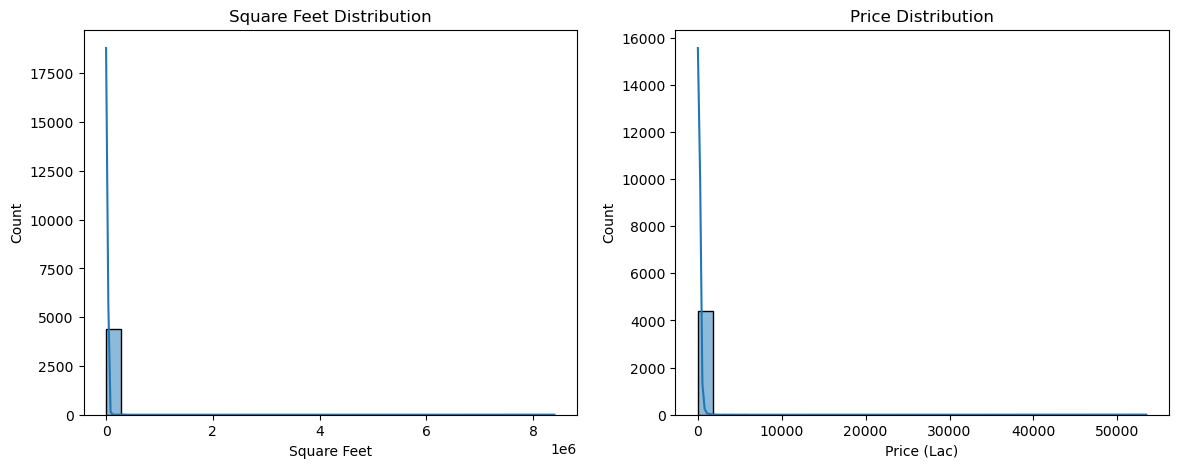

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df3['area_sqft'].dropna(), bins=30, ax=axes[0], kde=True)
axes[0].set_title("Square Feet Distribution")
axes[0].set_xlabel("Square Feet")
axes[0].set_ylabel("Count")

sns.histplot(df3['price_Lac'].dropna(), bins=30, ax=axes[1], kde=True)
axes[1].set_title("Price Distribution")
axes[1].set_xlabel("Price (Lac)")
axes[1].set_ylabel("Count")
plt.show()

This histogram on the left visualizes the distribution of **property sizes in square feet**. It helps us understand the spread and frequency of different property sizes in the dataset.The histogram (sns.histplot) groups area_sqft values into 30 bins, showing how often different property sizes appear. The KDE (Kernel Density Estimate) overlay provides a smoothed estimate of the distribution. Peaks in the histogram indicate the most common property sizes.

This histogram on the right shows the distribution of **property prices (in Lacs)**. It helps identify price trends, such as whether most properties are in a specific price range or if there are significant variations.Similar to the first plot, this histogram bins the price_Lac values into 30 groups and overlays a KDE curve. It helps us see how property prices are distributed and whether they are skewed towards lower or higher values.


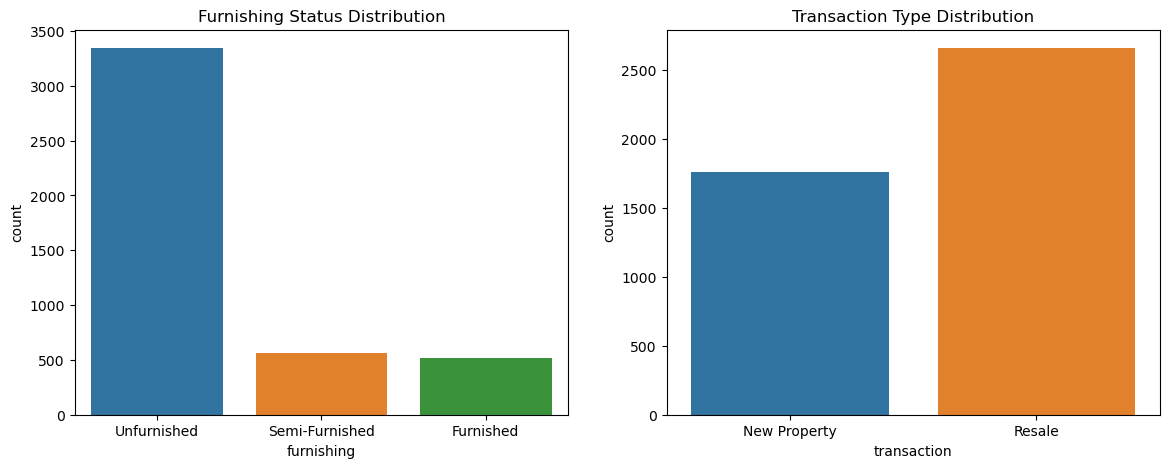

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='furnishing', data=df3, ax=axes[0])
axes[0].set_title("Furnishing Status Distribution")
sns.countplot(x='transaction', data=df3, ax=axes[1])
axes[1].set_title("Transaction Type Distribution")
plt.show()


The left bar chart displays the distribution of properties based on their **furnishing status**. It helps us understand how many properties are fully furnished, semi-furnished, or unfurnished in the dataset.The countplot counts the occurrences of each category in the furnishing column and plots them as bars. This allows us to see which furnishing type is most common and whether there is an imbalance in the dataset.

The right bar chart shows the distribution of properties by transaction type, such as resale or new sale. It helps analyze the **proportion of different transaction types** in the dataset. Similar to the first plot, this countplot counts and visualizes the occurrences of each category in the transaction column. This provides insights into whether most properties are newly sold or being resold.



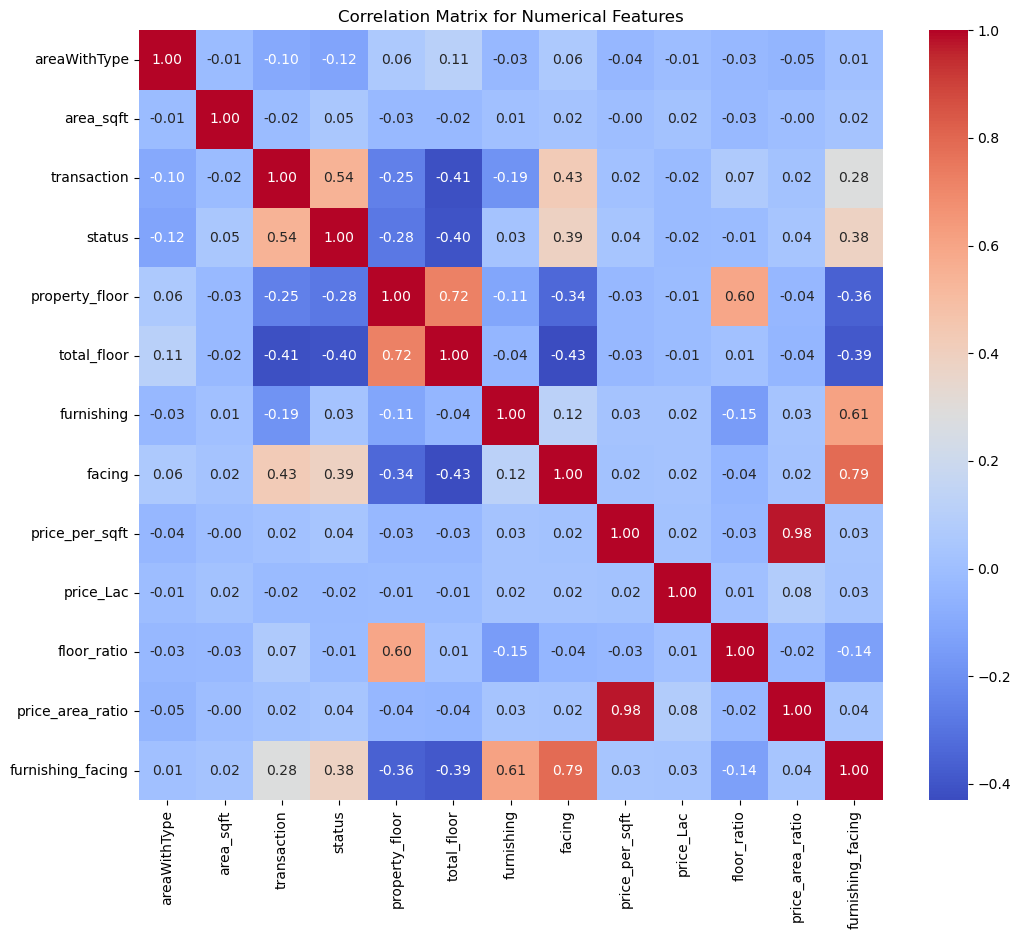

In [ ]:
num_cols = df_knn2.select_dtypes(include=[np.number]).columns
corr = df_knn2[num_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Numerical Features")
plt.show()

This heatmap visualizes the correlation between numerical features in the dataset. It helps identify relationships between variables and detect potential multicollinearity, which is useful for feature selection and model building.The corr() function computes the Pearson correlation coefficient between numerical columns.

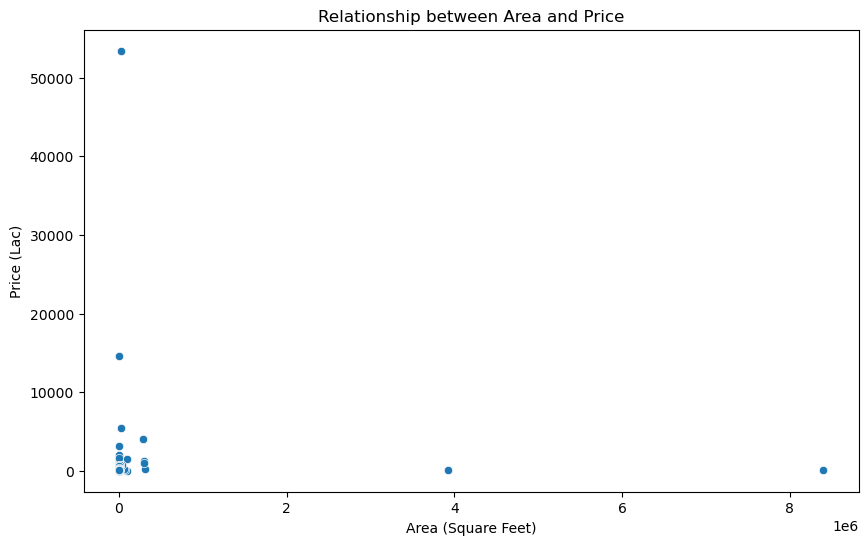

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='area_sqft', y='price_Lac', data=df3)
plt.title("Relationship between Area and Price")
plt.xlabel("Area (Square Feet)")
plt.ylabel("Price (Lac)")
plt.show()

This scatter plot examines the relationship between property area (in square feet) and price (in Lacs). It helps determine whether larger properties generally have higher prices and whether there are any noticeable trends or outliers.Each point represents a property, with its area on the x-axis and price on the y-axis.

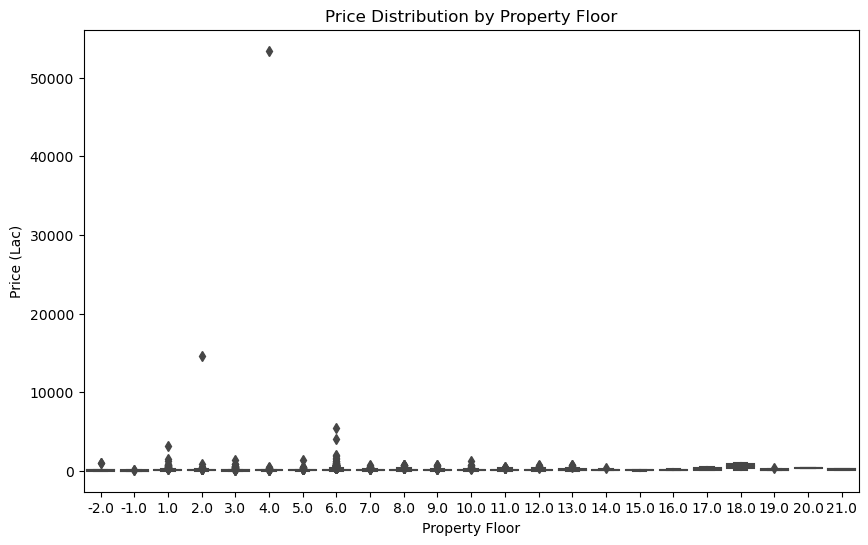

In [73]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='property_floor', y='price_Lac', data=df3)
plt.title("Price Distribution by Property Floor")
plt.xlabel("Property Floor")
plt.ylabel("Price (Lac)")
plt.show()

This boxplot visualizes the distribution of property prices across different floors, helping to analyze how property prices vary by floor level. It can reveal trends, such as whether higher-floor apartments tend to be more or less expensive.The x-axis represents different floor levels, while the y-axis represents property prices in Lacs.

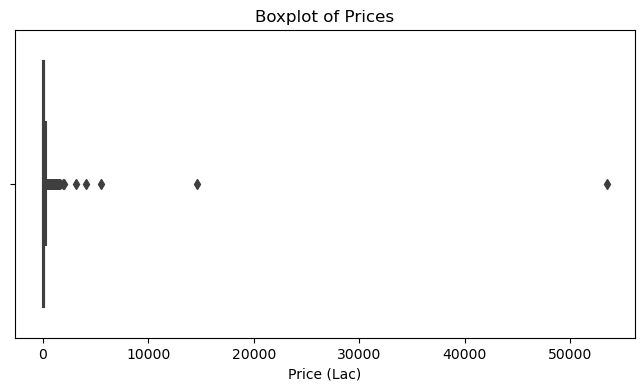

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.boxplot(x=df3['price_Lac'])
plt.title("Boxplot of Prices")
plt.xlabel("Price (Lac)")
plt.show()

This boxplot visualizes the distribution of property prices, helping to identify the spread of values, median price, and potential outliers.The box represents the interquartile range (IQR), which contains the middle 50% of the data.

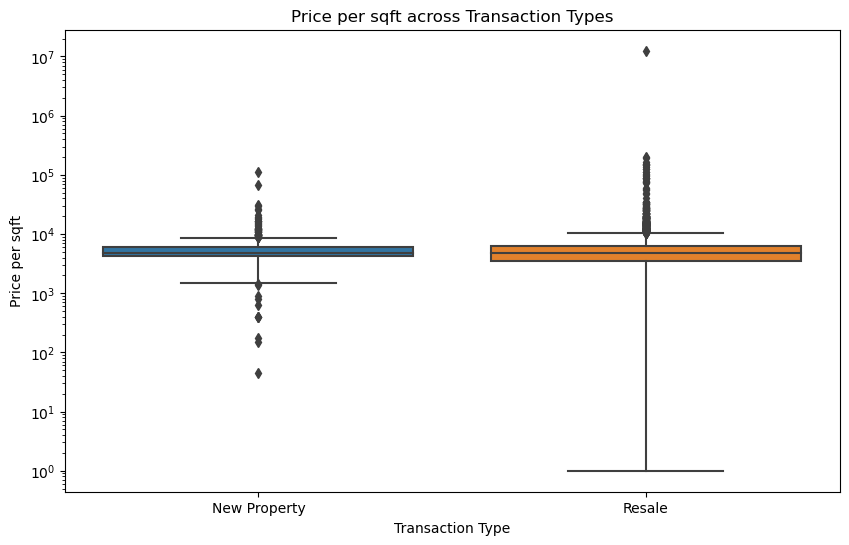

In [64]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df3['transaction'], y=df3['price_per_sqft'])
plt.yscale("log")
plt.xlabel("Transaction Type")
plt.ylabel("Price per sqft")
plt.title("Price per sqft across Transaction Types")
plt.show()

This boxplot compares the distribution of price per square foot (price_per_sqft) across **different transaction types**, helping to analyze price variations based on the type of transaction.The x-axis represents different transaction types (e.g., new sale, resale).The y-axis (log-scaled) represents the price per square foot. The log scale is used to better visualize price differences, especially if values vary widely.

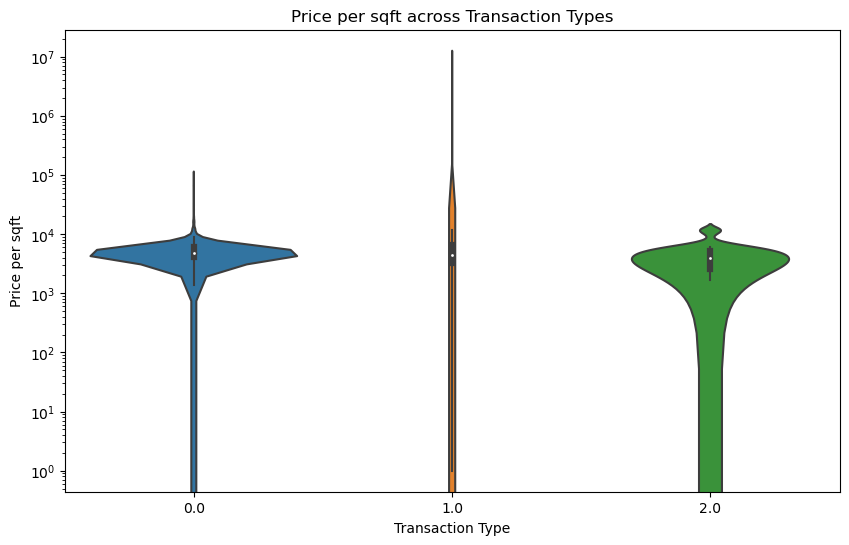

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(x='transaction', y='price_per_sqft', data=df_knn2)
plt.yscale("log")
plt.xlabel("Transaction Type")
plt.ylabel("Price per sqft")
plt.title("Price per sqft across Transaction Types")
plt.show()
#This violin plot visualizes the distribution of price per square foot (price_per_sqft) for different transaction types, combining features of both boxplots and density plots. It helps analyze price variations and distribution shapes.The x-axis represents different transaction types (e.g., new sale, resale).The y-axis (log-scaled) represents the price per square foot, helping to handle wide price variations.

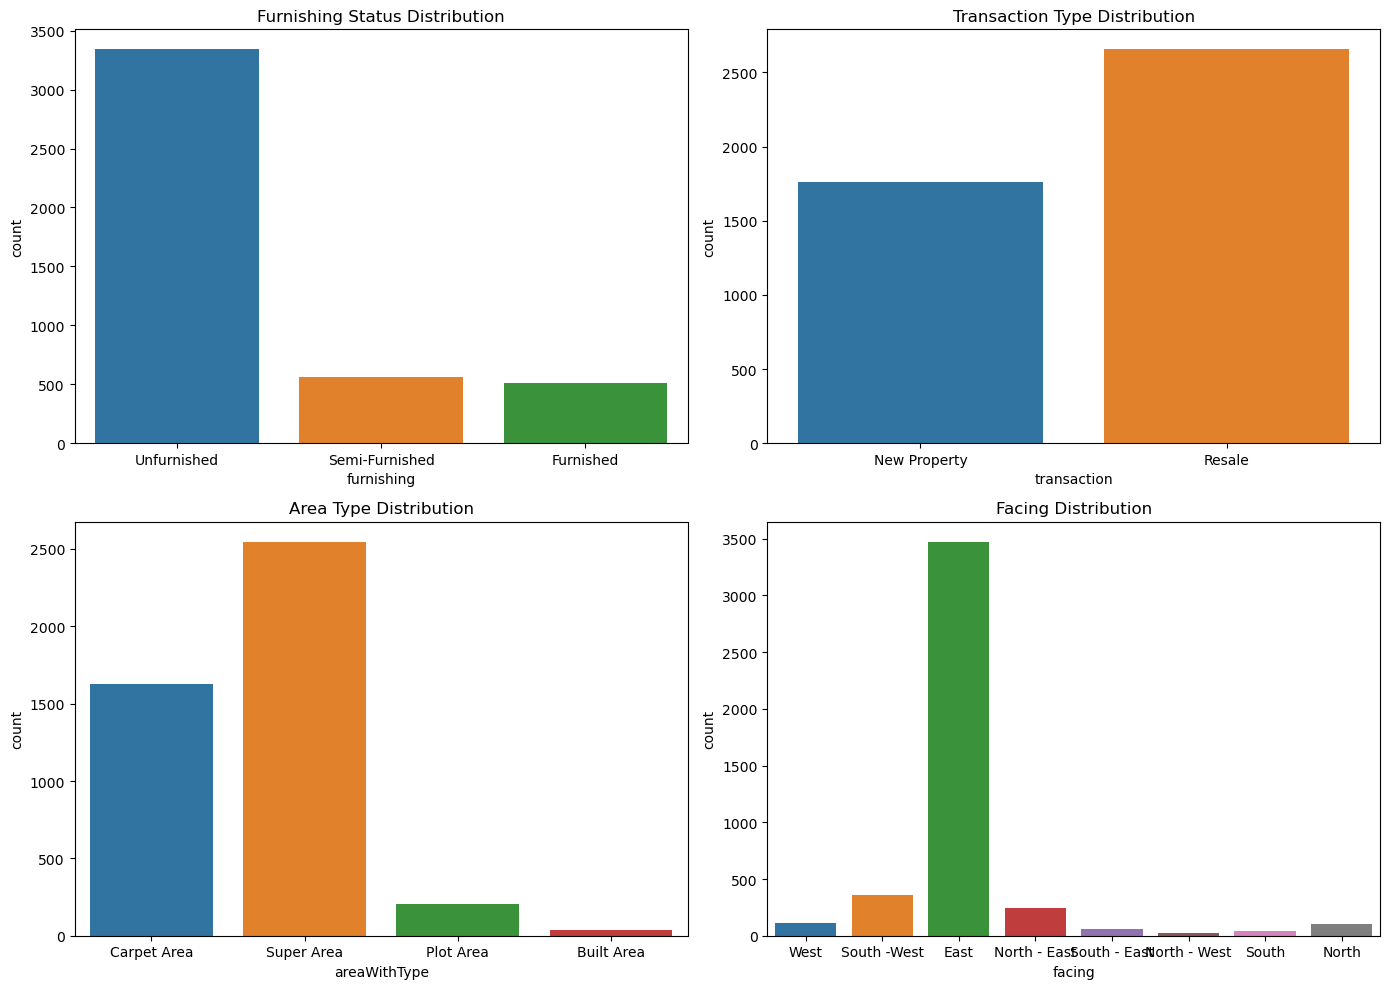

In [46]:
#The `df3` dataframe used mode imputation for missing values, making it more suitable for generating the following types of plots.
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.countplot(x='furnishing', data=df3, ax=axes[0, 0])
axes[0, 0].set_title("Furnishing Status Distribution")
#This count plot visualizes the distribution of properties based on their furnishing status. It helps to understand how many properties are furnished vs. unfurnished.The x-axis represents the different furnishing statuses (e.g., furnished, unfurnished).The count (number of properties) is plotted on the y-axis.
sns.countplot(x='transaction', data=df3, ax=axes[0, 1])
axes[0, 1].set_title("Transaction Type Distribution")
#This count plot shows the distribution of properties based on transaction type (e.g., new sale, resale).The x-axis represents the different transaction types.The y-axis shows the number of properties in each transaction category.
sns.countplot(x='areaWithType', data=df3, ax=axes[1, 0])
axes[1, 0].set_title("Area Type Distribution")
#This count plot visualizes the distribution of different area types (e.g., urban, suburban).Explanation:The x-axis shows different area types.The y-axis shows the count of properties in each area type.
sns.countplot(x='facing', data=df3, ax=axes[1, 1])
axes[1, 1].set_title("Facing Distribution")
#This count plot shows the distribution of properties based on their facing direction (e.g., north, south).The x-axis represents the different facing directions of the properties.The y-axis shows the count of properties with each facing.
plt.tight_layout()
plt.show()


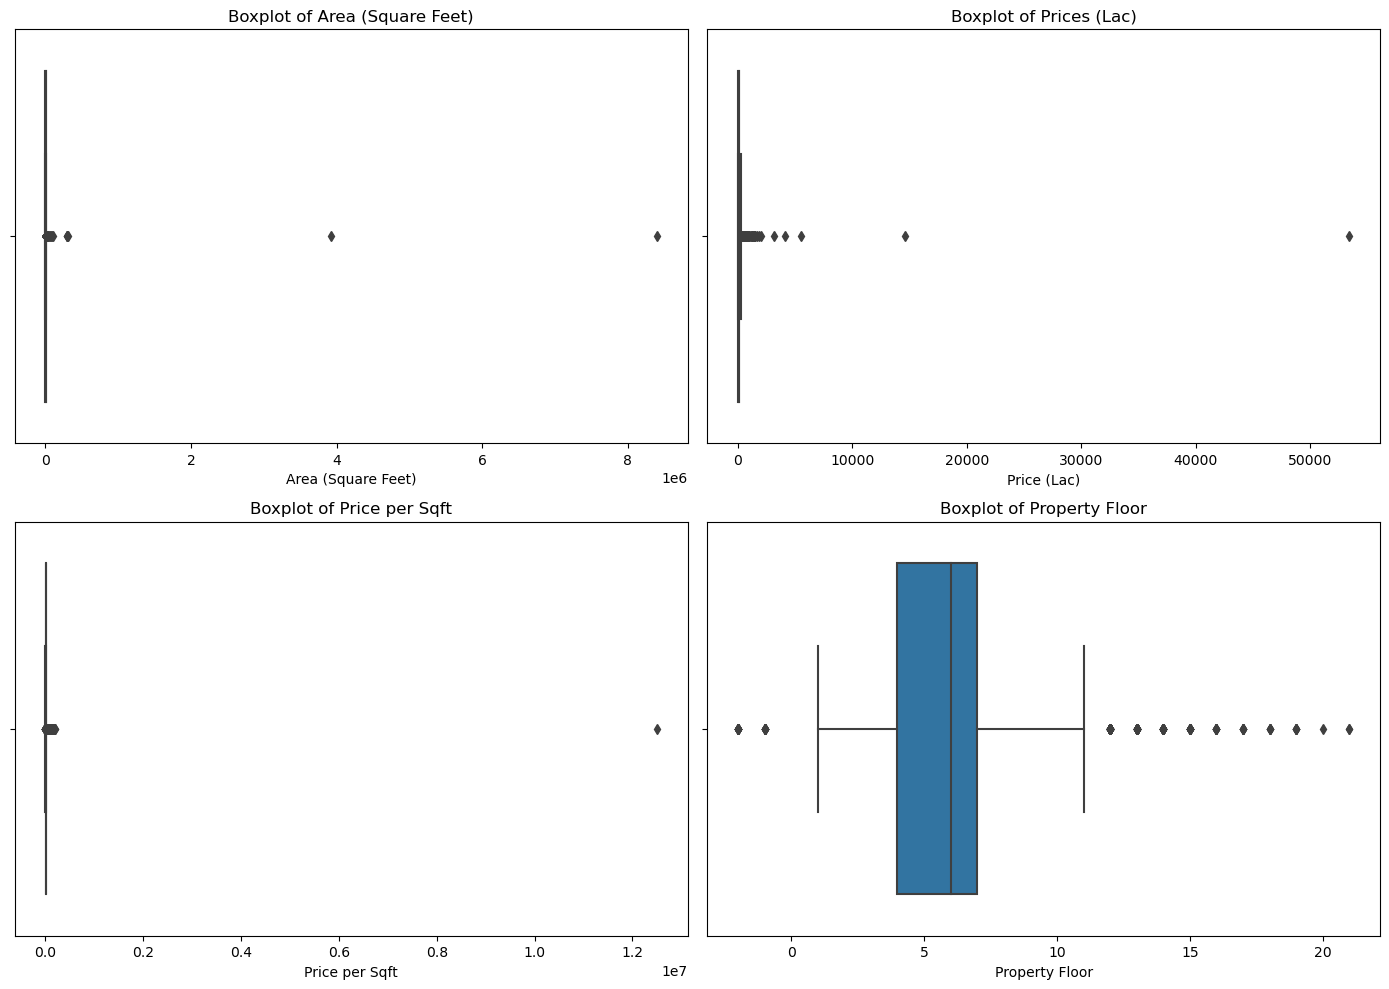

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(x=df3['area_sqft'], ax=axes[0, 0])
axes[0, 0].set_title("Boxplot of Area (Square Feet)")
axes[0, 0].set_xlabel("Area (Square Feet)")
#This boxplot visualizes the distribution of property areas (square feet), identifying the spread, central tendency, and potential outliers.The x-axis represents the area of properties (in square feet).The box shows the interquartile range (IQR), with the median line inside the box.
sns.boxplot(x=df3['price_Lac'], ax=axes[0, 1])
axes[0, 1].set_title("Boxplot of Prices (Lac)")
axes[0, 1].set_xlabel("Price (Lac)")
#This boxplot shows the distribution of property prices in Lac, highlighting the spread, central value, and outliers.The x-axis represents the property prices in Lac (units of 100,000).
sns.boxplot(x=df3['price_per_sqft'], ax=axes[1, 0])
axes[1, 0].set_title("Boxplot of Price per Sqft")
axes[1, 0].set_xlabel("Price per Sqft")
#This boxplot illustrates the distribution of the price per square foot, helping to understand how price varies with area.The x-axis represents the price per square foot.
sns.boxplot(x=df3['property_floor'], ax=axes[1, 1])
axes[1, 1].set_title("Boxplot of Property Floor")
axes[1, 1].set_xlabel("Property Floor")
#This boxplot shows the distribution of property prices across different property floors, which can help in understanding how floor level affects property pricing.The x-axis represents different property floors.
plt.tight_layout()
plt.show()


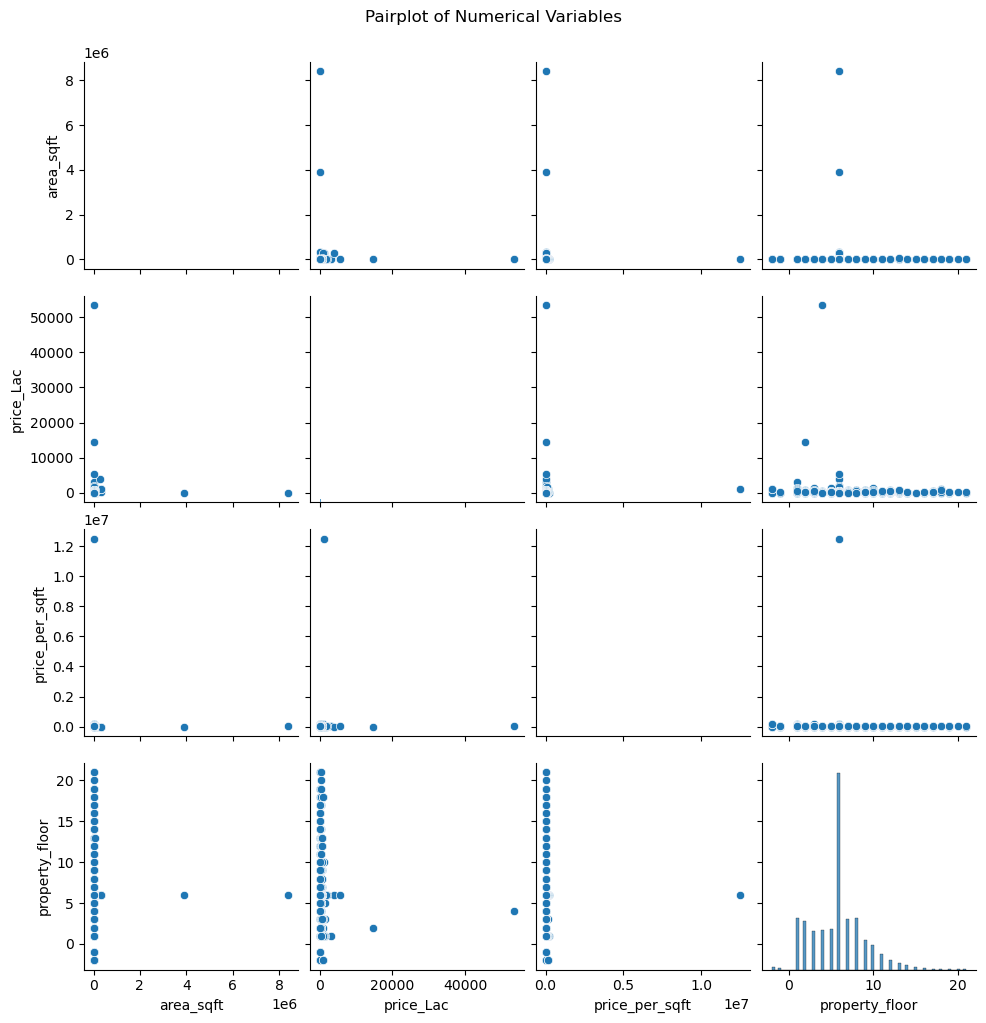

In [48]:
sns.pairplot(df3[['area_sqft', 'price_Lac', 'price_per_sqft', 'property_floor']])
plt.suptitle("Pairplot of Numerical Variables", y=1.02)
plt.show()
#The pairplot visualizes the relationships between multiple numerical variables and helps identify trends, correlations, and distributions of each feature. It provides scatterplots of all pairs of variables along with histograms on the diagonal.The plot compares the following numerical variables: area_sqft, price_Lac, price_per_sqft, and property_floor.The scatterplots off the diagonal show the pairwise relationships between each pair of variables.